In [1]:
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from submission.models import *
from submission.helpers import *
from evaluation import *

In [2]:
# Our input $x$
TEXT = torchtext.data.Field()
    
# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)


train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

# Build vocab
TEXT.build_vocab(train)
LABEL.build_vocab(train)

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
(train, val, test), batch_size=11, device=-1)

# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

# Multinomial NB

In [79]:
class MultinomialNB(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(MultinomialNB, self).__init__()
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)        
        self.n_positive = 0
        self.n_negative = 0
        # Smoothing para is 1 for all features
        self.p = torch.ones(self._text_vocab_len)
        self.q = torch.ones(self._text_vocab_len)
        self.r = None
        self.index_pos = LABEL.vocab.itos.index('positive')
        self.index_neg = LABEL.vocab.itos.index('negative')

    # could use EmbeddingsBag, but there's not a huge difference in
    # performance
    def get_features(self, batch):
        size_batch = batch.size()[0]
        features = torch.zeros(size_batch, self._text_vocab_len)
        for i in range(size_batch):
            for j in batch[i, :]:
                features[i, j.data[0]] += 1
        return features
        # return torch.Tensor(features)

    def train(self, train_iter):
        # There's probably a better way to do this
        num_iter = len(train_iter)
        train_iter = iter(train_iter)
        for i in range(num_iter):
            batch = next(train_iter)
            if i % 100 == 0:
                print(i)
            # Should be [N, num-features]
            features = self.get_features(torch.t(batch.text).contiguous())

            # Using broadcasting
            inds_pos = torch.nonzero(batch.label.data == self.index_pos)
            inds_neg = torch.nonzero(batch.label.data == self.index_neg)


            if inds_pos.size():
                self.n_positive += inds_pos.size()[0]
                self.p = torch.add(self.p, torch.sum(features[inds_pos, :], dim=0))                
            if inds_neg.size():
                self.n_negative += inds_neg.size()[0]
                self.q = torch.add(self.q, torch.sum(features[inds_neg, :], dim=0))

            # print(features)
            # print(inds_neg, inds_pos)
            # print(self.p.size(), torch.sum(features, dim=0).size())

        self.r = torch.log((self.p / self.p.sum()) / (self.q / self.q.sum()))
        
    def forward(self, batch):
        # for k in range(batch_text.size()[1]):
        features = self.get_features(batch)
        # Using broadcasting
        return torch.matmul(features, torch.squeeze(self.r)) + \
            np.log(self.n_positive / self.n_negative)

In [80]:
mnb = MultinomialNB(TEXT, LABEL)
mnb.train(train_iter)

0
100
200
300
400
500
600


In [81]:
evaluator = TextEvaluator(mnb)
evaluator.score(test_iter)

Iteration 0, predictions: [1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2]
Accuracy: 1501 1821 0.8242723778143877


# Log Reg

Iteration 0, loss: 1.098945
Iteration 100, loss: 0.701653
Iteration 200, loss: 0.722097
Iteration 300, loss: 0.489957
Iteration 400, loss: 0.523434
Iteration 500, loss: 0.583470
Iteration 600, loss: 0.558396
Iteration 700, loss: 0.655203
Iteration 800, loss: 0.791233
Iteration 900, loss: 0.366011


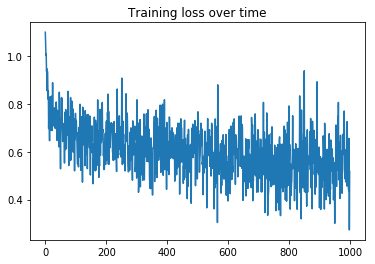

In [86]:
lr = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, lr)
trainer.train(train_iter)

In [87]:
evaluator = TextEvaluator(lr)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2]
Accuracy: 1308 1821 0.7182866556836903


# CBOW

Iteration 0, loss: 1.648201
Iteration 100, loss: 1.621424
Iteration 200, loss: 0.922567
Iteration 300, loss: 1.007872
Iteration 400, loss: 0.570381
Iteration 500, loss: 0.767750
Iteration 600, loss: 0.304812
Iteration 700, loss: 0.182766
Iteration 800, loss: 0.766858
Iteration 900, loss: 0.604174


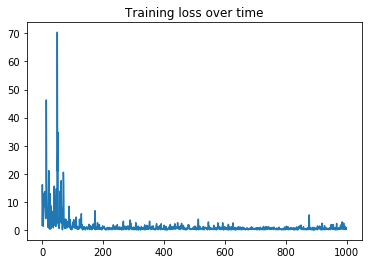

In [26]:
cbow = CBOW(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL, cbow)
trainer.train(train_iter)

In [28]:
evaluator = TextEvaluator(cbow)
evaluator.score(test_iter)

Iteration 0, predictions: [2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2]
Iteration 100, predictions: [2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2]
Accuracy: 1392 1821 0.7644151565074135


# CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        C = len(LABEL.vocab)
        in_channels = 1
        out_channels = 100
        kernel_sizes = [2,3] 
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # Linear layer
        self.linear = nn.Linear(TEXT.vocab.vectors.size()[1], len(LABEL.vocab))

        # List of convolutional layers
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels, out_channels, (K, D)) for K in kernel_sizes])

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, C)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, out_channels, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, out_channels, W), ...]*len(kernel_sizes)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, out_channels), ...]*len(kernel_sizes)
        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = F.log_softmax(self.fc1(x), dim=1)  # (N, C)
        return logit

In [141]:
class CNN(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(CNN, self).__init__()
        
        N = TEXT.vocab.vectors.size()[0]
        D = TEXT.vocab.vectors.size()[1]
        C = 2
        in_channels = 1
        out_channels = 100
        kernel_sizes = [3, 4, 5] 
        
        self.embeddings = nn.Embedding(N, D)
        self.embeddings.weight = nn.Parameter(TEXT.vocab.vectors, requires_grad=True)
        
        # List of convolutional layers
        self.convs1 = nn.ModuleList([nn.Conv2d(in_channels,
                                               out_channels,
                                               (K, D),
                                               padding=(K-1, 0)) \
                                     for K in kernel_sizes])

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(kernel_sizes)*out_channels, 2)

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, out_channels, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x

    def forward(self, x):
        x = self.embeddings(x)  # (N, W, D)

        x = x.unsqueeze(1)  # (N, in_channels, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, out_channels, W)]*len(kernel_sizes)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, out_channels)]*len(kernel_sizes)
        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(kernet_sizes)*out_channels)
        logit = F.log_softmax(self.fc1(x))  # (N, C)
        return logit


In [142]:
class TextTrainerBinary(object):
    def __init__(self, TEXT, LABEL, model, optimizer=optim.SGD):
        # NLLLoss works with labels, not 1-hot encoding
        self._loss_fn = nn.NLLLoss()
        self._optimizer = optimizer(filter(lambda p : p.requires_grad,
                                           model.parameters()), lr=0.1)
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)
        self._model = model
        
        # For review and assessment
        self._training_losses = []

    # TODO: this is horribly slow, can use nn.EmbeddingsBag and put
    # this in LogisticRegression class!
    def get_feature(self, batch):
        # Need transpose so that batch size is first dimension; need
        # contiguous because of the transpose
        return torch.t(batch.text.data).contiguous()
        # size_batch = batch.text.size()[1]
        # features = torch.zeros(size_batch, self._text_vocab_len)
        # for i in range(size_batch):
        #     for j in batch.text[:, i]:
        #         features[i, j.data[0]] += 1
        # return features
    
    def get_label(self, batch):
        labels = batch.label.data - 1
        labels[labels < 0] = 0
        return labels
    
    def make_loss(self, batch):
        bow = autograd.Variable(self.get_feature(batch))
        label = autograd.Variable(self.get_label(batch))
        loss = self._loss_fn(self._model(bow), label)
        return loss
    
    def train(self, train_iter, num_iter=1000, skip_iter=100, plot=True):
        for i in range(num_iter):
            batch = next(iter(train_iter))
            self._model.zero_grad()
            loss = self.make_loss(batch)
            
            loss_val = loss.data.numpy()[0] 
            self._training_losses.append(loss_val)
            if i % skip_iter == 0:
                print('Iteration %d, loss: %f' % (i, loss_val))
            loss.backward()
            self._optimizer.step()
        if plot:
            plt.plot(np.arange(len(self._training_losses)), self._training_losses)
            plt.title("Training loss over time")
            plt.show()

In [143]:
cnn = CNN(TEXT, LABEL)
trainer = TextTrainerBinary(TEXT, LABEL, cnn)
trainer.train(train_iter, num_iter=2500)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, loss: 0.730696
Iteration 100, loss: 0.553889
Iteration 200, loss: 0.308245
Iteration 300, loss: 0.560873
Iteration 400, loss: 0.184231
Iteration 500, loss: 0.110836
Iteration 600, loss: 0.325485
Iteration 700, loss: 0.331630
Iteration 800, loss: 0.101331
Iteration 900, loss: 0.102746
Iteration 1000, loss: 0.010174
Iteration 1100, loss: 0.017415
Iteration 1200, loss: 0.017602
Iteration 1300, loss: 0.030811
Iteration 1400, loss: 0.058454


KeyboardInterrupt: 

In [119]:
class TextEvaluator(object):
    def __init__(self, model):
        self._predictions = []
        self._model = model
        
    def get_label(self, batch):
        labels = batch.label.data - 1
        labels[labels < 0] = 0
        return labels

    def score(self, test_iter, predictions_file="", mnb=False):
        correct = 0
        total = 0
        for i,batch in enumerate(test_iter):
            # Get predictions
            probs = self._model(torch.t(batch.text).contiguous())
            if mnb:
                signs = torch.sign(probs).type(torch.LongTensor)
                classes = (signs + 1) * (self._model.index_pos - self._model.index_neg) / 2 + \
                          self._model.index_neg
                # print(classes, probs)
            else:
                _, argmax = probs.max(1)
                classes = argmax.data
            if i % 100 == 0:
                print('Iteration %d, predictions:' % (i), list(classes))
            self._predictions += list(classes)

            labels = self.get_label(batch)
            correct += (classes == labels).sum()
            total += len(labels)

        print("Accuracy:", correct, total, correct/total)
        if predictions_file:
            with open(predictions_file, "w") as f:
                f.write("Id,Cat\n")
                for index,p in enumerate(self._predictions):
                    f.write(str(index) + "," + str(p) + "\n")

In [144]:
evaluator = TextEvaluator(cnn)
evaluator.score(test_iter)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, predictions: [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Iteration 100, predictions: [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Accuracy: 1468 1821 0.8061504667764964


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  


In [145]:
class Ensemble(nn.Module):
    def __init__(self, TEST, LABEL):
        super(Ensemble, self).__init__()
        
        num_models = 2
        C = len(LABEL.vocab)
        self.linear = nn.Linear(num_models, C)

    def get_classes(self, probs, model):
        if len(probs.size()) == 1 or (len(probs.size()) == 2 \
                                      and probs.size()[1] == 1):
            signs = torch.sign(probs).type(torch.LongTensor)
            classes = (signs + 1) * (model.index_pos - model.index_neg) / 2 + \
                      model.index_neg
            # print(classes, probs)
        else:
            _, argmax = probs.max(1)
            classes = argmax.data
        return classes.view(1,len(classes))

    def forward(self, x):
        y1 = self.get_classes(mnb(x), mnb)
        y2 = self.get_classes(cnn(x), cnn)
        y3 = self.get_classes(lr(x), lr)
        y4 = self.get_classes(cbow(x), cbow)
        
        y = torch.t(torch.cat((y1, y2)).float())

        logit = F.log_softmax(self.linear(autograd.Variable(y)), dim=1)  # (N, C)
        return logit


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, loss: 2.416485
Iteration 100, loss: 0.387703
Iteration 200, loss: 0.129495
Iteration 300, loss: 0.102211
Iteration 400, loss: 0.085366
Iteration 500, loss: 0.078172
Iteration 600, loss: 0.058681
Iteration 700, loss: 0.049245
Iteration 800, loss: 0.044378
Iteration 900, loss: 0.231263
Iteration 1000, loss: 0.336776
Iteration 1100, loss: 0.038051
Iteration 1200, loss: 0.051022
Iteration 1300, loss: 0.038274
Iteration 1400, loss: 0.028956
Iteration 1500, loss: 0.386948
Iteration 1600, loss: 0.049786
Iteration 1700, loss: 0.037954
Iteration 1800, loss: 0.023425
Iteration 1900, loss: 0.036654


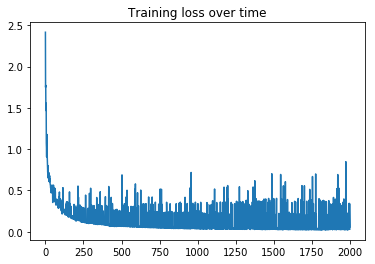

In [148]:
ensemble = Ensemble(TEXT, LABEL)
trainer = TextTrainerBinary(TEXT, LABEL, ensemble)
trainer.train(train_iter, num_iter=2000)

In [150]:
evaluator = TextEvaluator(ensemble)
evaluator.score(test_iter)

//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, predictions: [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
Iteration 100, predictions: [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Accuracy: 1454 1821 0.7984623833058759


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  
